### Implementation of the Fully Connected One Stage (FCOS) object detection algorithm with training/eval on the PASCAL VOC 2007 dataset. 
(FCOS paper: https://arxiv.org/abs/1904.01355)

(FPNP paper: https://arxiv.org/abs/1612.03144)

Make sure the data has been downloaded (http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar) and extracted. The 'JPEGImages' subdirectory contains all the raw jpeg images. The 'Annotations' subdirectory contains corresponding XML files with object detection labels/metadata. The 'ImageSets/Main' subdirectory contains .txt files 'train.txt', 'val.txt' which contain identifiers of images for training and validation splits respectively. (There are also additional .txt files containing identifiers for images per class for each split).

In [1]:
import os
import random
import math
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt 
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision import models
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data._utils.collate import default_collate
from torchvision.ops import sigmoid_focal_loss, nms
from tqdm import tqdm

In [2]:
# first lets read in the image identifiers for train-val splits
with open(os.path.join('VOC2007_trainval', 'ImageSets', 'Main', 'train.txt')) as file:
    identifiers_train = [line.strip() for line in file.readlines()]

with open(os.path.join('VOC2007_trainval', 'ImageSets', 'Main', 'val.txt')) as file:
    identifiers_val = [line.strip() for line in file.readlines()]

# now get the jpeg filepaths for the images
image_filepaths_train = [os.path.join('VOC2007_trainval','JPEGImages',x+'.jpg') for x in identifiers_train]    
image_filepaths_val = [os.path.join('VOC2007_trainval','JPEGImages',x+'.jpg') for x in identifiers_val]    

# get the xml filepaths to object detection target labels
target_filepaths_train = [os.path.join('VOC2007_trainval','Annotations',x+'.xml') for x in identifiers_train]    
target_filepaths_val = [os.path.join('VOC2007_trainval','Annotations',x+'.xml') for x in identifiers_val]    

print(f"Num train images: {len(image_filepaths_train)}")
print(f"Num val images: {len(image_filepaths_val)}")

Num train images: 2501
Num val images: 2510


We will set up a pytorch Dataset object for accessing image-target pairs

In [3]:
class VOC2007(torch.utils.data.Dataset):
    def __init__(self, dataset_dir='VOC2007_trainval', split='train', image_size=256, num_boxes=40):
        super().__init__()
        self.image_size = image_size
        self.num_boxes = num_boxes # max number of object boxes per image

        # first lets read in the image identifiers for train-val splits
        with open(os.path.join(dataset_dir, 'ImageSets', 'Main', split+'.txt')) as file:
            identifiers = [line.strip() for line in file.readlines()]
        # now get the jpeg filepaths for the images
        self.image_filepaths = [os.path.join(dataset_dir,'JPEGImages',x+'.jpg') for x in identifiers]    
        # get the xml filepaths to object detection target labels
        self.target_filepaths = [os.path.join(dataset_dir,'Annotations',x+'.xml') for x in identifiers]    
        # get the target label annotations for all images
        self.image_annotations = [self.parse_xml(filepath) for filepath in self.target_filepaths]
        # class names
        voc_classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog",
            "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
        # class name <-> integer mapping
        self.class2idx = {c:i for i,c in enumerate(voc_classes)}
        self.idx2class = {i:c for i,c in enumerate(voc_classes)}
        
        # define transformations for image preprocessing
        self.transforms = transforms.Compose([
            transforms.Resize(self.image_size), # resize maintining original aspect ratio
            transforms.CenterCrop(self.image_size), # do center crop to make square image
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalzie to have same mean and std as ImageNet
        ])


    def __len__(self):
        return len(self.image_filepaths)

    def __getitem__(self, index):
        # get image filepath and annotations dictionary
        image_filepath, annotation = self.image_filepaths[index], self.image_annotations[index] 
        # load the RGB image
        image = Image.open(image_filepath).convert('RGB')
        # make tensor of class labels per box
        gt_classes = torch.tensor([self.class2idx[obj['class']] for obj in annotation['objects']]).unsqueeze(1) # shape: (N,1)
        # make tensor of boxes (N boxes, each with xyxy boundiong box coordinates)
        gt_boxes = torch.tensor([obj['bndbox'] for obj in annotation['objects']], dtype=torch.float) # shape: (N,4)
        # normalize bounding box coordinates to be in [0,1] w.r.t. original image size
        W, H = image.size
        norm = torch.tensor([[W,H,W,H]])
        gt_boxes /= norm 
        # preprocess image, transform to tensor
        image = self.transforms(image)    
       
        # now transform the bounding boxes accordingly to match the transformed image dimensions
        if H >= W:
            # size of transforms.Resize() 
            # (if H>=W, then transforms.Resize() output size will be (H*image_size/W, image_size) else output size will be (image_size,W*image_size/H))
            H_new = H * self.image_size / W
            W_new = self.image_size 
        else:
            H_new = self.image_size
            W_new = W * self.image_size / H
        # center-crop shift amount        
        dxc = (W_new - self.image_size) // 2    
        dyc = (H_new - self.image_size) // 2    

        # unnormalize bounding box coordinates and shift for center-crop, also clamp to (0,image_size)
        gt_boxes[:,0] = torch.clamp(gt_boxes[:,0] * W_new - dxc ,min=0)
        gt_boxes[:,1] = torch.clamp(gt_boxes[:,1] * H_new - dyc ,min=0)
        gt_boxes[:,2] = torch.clamp(gt_boxes[:,2] * W_new - dxc ,max=self.image_size)
        gt_boxes[:,3] = torch.clamp(gt_boxes[:,3] * H_new - dyc ,max=self.image_size)

        # concatenate bounding box coordinates and class labels into single tensor of shape (N,5)
        gt_boxes = torch.cat([gt_boxes, gt_classes], dim=1)
        # set invalid boxes to -1
        invalid = (gt_boxes[:,0] > gt_boxes[:,2]) | (gt_boxes[:,1] > gt_boxes[:,3]) 
        gt_boxes[invalid] = -1
        # apply padding to make N fixed size
        gt_boxes = torch.cat([gt_boxes[:self.num_boxes], torch.full((self.num_boxes-len(gt_boxes),5), -1.0)])

        return image_filepath, image, gt_boxes

    # fucntion for parsing XML file to get object detection target labels
    def parse_xml(self, filepath):
        # start at the root of the XML tree
        root_node = ET.parse(filepath).getroot()
        annotations = {}
        # get all the object bounding boxes
        objects = []
        for obj in root_node.findall('object'):
            # for each object, get class name, difficulty identifier (0: easy, 1: difficult) and bounding box (xyxy: top-left and bottom-right corner coordinates) 
            object_dict = {
                'class': obj.find('name').text,
                'difficult': obj.find('difficult').text,
                'bndbox': [int(obj.find('bndbox/xmin').text), 
                           int(obj.find('bndbox/ymin').text),
                           int(obj.find('bndbox/xmax').text), 
                           int(obj.find('bndbox/ymax').text)]

            }
            objects.append(object_dict)
        annotations['objects'] = objects
        return annotations    
    

# tranform for unnormalizing an image from the dataset
unnormalize = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]), 
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]) ])    

# function for visualizing image with target boxes
def visualize(dataset, index=None):
    if not index:
        # grab a random image from dataset if no index provided
        index = random.randint(0,len(dataset)-1)
    _, image, gt_boxes = dataset[index]

    # unnormalize the image
    image = unnormalize(image)
    # only keep non-padding boxes
    nonpad = gt_boxes[:,4]>=0
    gt_boxes = gt_boxes[nonpad]
    # reshape image from (C,H,W) -> (H,W,C) and conert to numpy uint array
    image = (image *255).permute(1,2,0).numpy().astype("uint8")
    # plot image
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis("off")
    # plot object bounding boxes with class label
    for i in range(len(gt_boxes)):
        xmin, ymin, xmax, ymax = gt_boxes[i,0:4]
        class_label = dataset.idx2class[gt_boxes[i,-1].item()]
        rectangle = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=3, linestyle="solid", edgecolor='r', fill=False)
        ax.add_patch(rectangle)
        ax.text(xmin, ymin, class_label, size=18, family="sans-serif", 
                bbox={"facecolor": "black", "alpha": 0.8,"pad": 0.7, "edgecolor": "none"},
                verticalalignment="top", color=(1, 1, 1), zorder=10,)

    plt.show()


In [4]:
# create train-val datasets
train_dataset = VOC2007(split='train')
val_dataset = VOC2007(split='val')

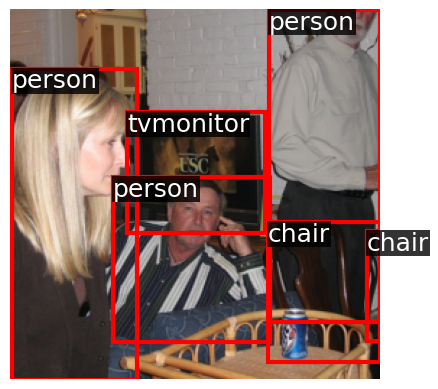

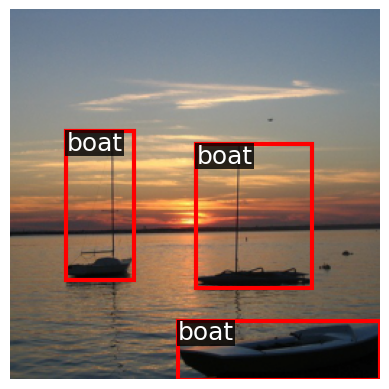

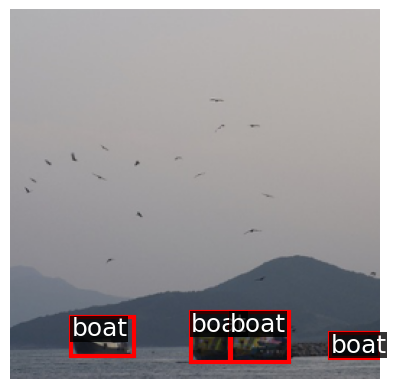

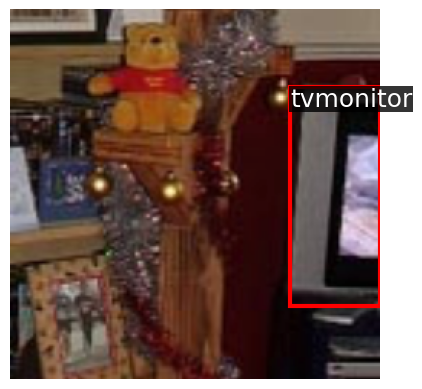

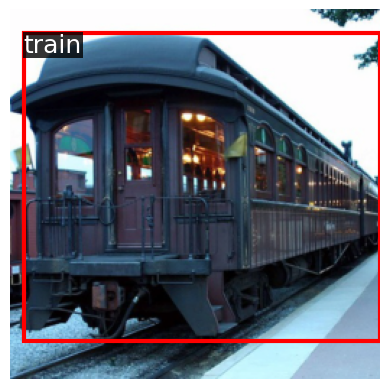

In [5]:
# visualize some imagaes from training set
for i in range(5):
    visualize(train_dataset)

#### Building the Model: The FCOS model has 3 main components: 1) Backbone network for feature extraction (pre-trained on imagenet, weights frozen), 2) Feature pyramid and 3) Prediction Head.

Following the FCOS paper, we will extract feature maps from three different conv layers from the backbone: C3, C4 and C5, with strides s = 8, 16 and 32 respectively (where stride of a layer c is defined as the downsampling ratio of the feature map size to the original input image size). The feature pyramid will have 5 levels P3 - P7. The P5 level pyramid map is computed by applying 1x1 conv followed by 3x3 conv to the C5 feature map (both convolutions have same padding). Then  P6 is computed by downsampling P5 with convolution of stride=2, similarly P7 is computed using strided convolution of P6. Then each lower pyramid level (P4, P3) is computed by merging (elementwise adding) the 1x1 convolution of the corresponding feature map with the upsampled pyramid level (simple upsampling will suffice, e.g. interpolation with nearest pixel) from above and then applying a 3x3 conv , e.g. P4 = conv3x3(conv1x1(C4) + upsample(P5)), both convolutions have same padding.

The FCOS prediction head will contain two branches, each identical stem is a sequence of conv-relu layers (with same padding), one for per-feature pixel object classification and the other stem for computing regression of box centerness and bounding box location in parallel (the bounding box location outputs need to be passed thourgh an exponential function to ensure positivity, also the FCOS paper uses a learnable sclaing parameter parameter before applying the exponential). The shared head is used to compute predictions across all fpn levels. 

The FCOS algorithm also uses the `Focal Loss` function to compute the object classification loss to componsate for the imbalanced class labels (way more background than actual objects). 

Note: we use same padding for convolutions such that the input at the final classification/regression layers have the same spatial size as the backbone feature maps, this is because we want to do compute per feature/pixel predictions. 

(See Figure 2. from FCOS paper)

#### We will implement the backbone with feature pyramid network and the prediction head separately.

In [6]:
"""
# first, need to figure out which layers to extract from backbone features from by forward passing dummy inputn and inspecting shapes of each block's output
regnet = models.regnet_x_3_2gf(pretrained=True) # smaller backbone
backbone = create_feature_extractor(
            regnet,
            return_nodes={
                "trunk_output.block1": "block1",
                "trunk_output.block2": "block2",
                "trunk_output.block3": "block3",
                "trunk_output.block4": "block4",
            },
        )

# batch of 2 dummy images
dummy_input = torch.randn((2,3,256,256))
dummy_output = backbone(dummy_input)

for layername, output in dummy_output.items():
    print(f"Layer: {layername}, output shape: {output.shape}, downsample ratio: ({dummy_input.shape[-2]/output.shape[-2]}, {dummy_input.shape[-1]/output.shape[-1]})")
"""

'\n# first, need to figure out which layers to extract from backbone features from by forward passing dummy inputn and inspecting shapes of each block\'s output\nregnet = models.regnet_x_3_2gf(pretrained=True) # smaller backbone\nbackbone = create_feature_extractor(\n            regnet,\n            return_nodes={\n                "trunk_output.block1": "block1",\n                "trunk_output.block2": "block2",\n                "trunk_output.block3": "block3",\n                "trunk_output.block4": "block4",\n            },\n        )\n\n# batch of 2 dummy images\ndummy_input = torch.randn((2,3,256,256))\ndummy_output = backbone(dummy_input)\n\nfor layername, output in dummy_output.items():\n    print(f"Layer: {layername}, output shape: {output.shape}, downsample ratio: ({dummy_input.shape[-2]/output.shape[-2]}, {dummy_input.shape[-1]/output.shape[-1]})")\n'

Note that outputs from blocks 2, 3 and 4 have the strides that we're looking for.

In [7]:
class BackboneFPN(nn.Module):
   """
      Args:
         out_channels: number of channels in the feature pyramid maps 
   """
   def __init__(self, out_channels):
      super().__init__()
      self.out_channels = out_channels # number of channels in feature pyramid maps

      # initialize backbone model, we will use RegNet
      regnet = models.regnet_x_3_2gf(pretrained=True)  # medium backbone
      self.backbone = create_feature_extractor(
                  regnet,
                  return_nodes={
                     "trunk_output.block2": "c3",
                     "trunk_output.block3": "c4",
                     "trunk_output.block4": "c5",
                  })
      
      # foprward pass dummy input to get feature map sizes
      dummy_input = torch.randn((2,3,256,256))
      dummy_output = self.backbone(dummy_input)

      # conv layers for pyramid maps
      self.fpn_params = nn.ModuleDict()

      # 1x1 lateral convs
      c3_channels = dummy_output['c3'].shape[1]
      c4_channels = dummy_output['c4'].shape[1]
      c5_channels = dummy_output['c5'].shape[1]
      self.fpn_params['lateral_conv_c3'] = nn.Conv2d(c3_channels, out_channels, kernel_size=1)
      self.fpn_params['lateral_conv_c4'] = nn.Conv2d(c4_channels, out_channels, kernel_size=1)
      self.fpn_params['lateral_conv_c5'] = nn.Conv2d(c5_channels, out_channels, kernel_size=1)
      # 3x3 convs (helps with anti-alisaing the merged pyramid outputs)
      self.fpn_params['merge_conv_c3'] = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
      self.fpn_params['merge_conv_c4'] = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
      self.fpn_params['merge_conv_c5'] = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
      # 3x3 conv with stride 2 for P6, P7 levels
      self.fpn_params['downsample_conv_p6'] = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=2)
      self.fpn_params['dopwnsample_conv_p7'] = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=2)


   @property
   def fpn_strides(self):
      """
         Input Image shape: (C, H, W)
         P3 shape: (out_channels, H/8, W/8)     stride = 8
         P4 shape: (out_channels, H/16, W/16)   stride = 16
         P5 shape: (out_channels, H/32, W/32)   stride = 32
         P6 shape: (out_channels, H/64, W/64)   stride = 64
         P7 shape: (out_channels, H/128, W/128) stride = 128
      """   
      return {'p3': 8, 'p4': 16, 'p5': 32, 'p6': 64, 'p7': 128}


   # FPN forward pass
   """
      Args:
         images: input image batch tensor of shape (N,C,H,W) where N is the batch size
      
      Returns:
         fpn_feats: dictionary of feature pyramid map tensors for each level (p3-p7)
   """
   def forward(self, images):
      # extract backbone features
      backbone_feats = self.backbone(images)
      # compute FPN maps
      c3 = backbone_feats['c3'] # shape: (N,out_channels, H/8, W/8)
      c4 = backbone_feats['c4'] # shape: (N,out_channels, H/16, W/16)
      c5 = backbone_feats['c5'] # shape: (N,out_channels, H/32, W/32)
      p5 = self.fpn_params['merge_conv_c5'](self.fpn_params['lateral_conv_c5'](c5)) # shape: (N,out_channels, H/32, W/32)
      p4 = self.fpn_params['merge_conv_c4'](F.interpolate(p5, scale_factor=2, mode='nearest') + self.fpn_params['lateral_conv_c4'](c4)) # shape: (N,out_channels, H/16, W/16)
      p3 = self.fpn_params['merge_conv_c3'](F.interpolate(p4, scale_factor=2, mode='nearest') + self.fpn_params['lateral_conv_c3'](c3)) # shape: (N,out_channels, H/8, W/8)
      p6 = self.fpn_params['downsample_conv_p6'](p5)  # shape: (N,out_channels, H/64, W/64)
      p7 = self.fpn_params['downsample_conv_p6'](p6)  # shape: (N,out_channels, H/128, W/128)

      fpn_feats = {'p3' : p3, 'p4' : p4, 'p5' : p5, 'p6' : p6, 'p7' : p7}
      return fpn_feats


In [8]:
# test to make sure output shapes are correct
"""
fpn_model = BackboneFPN(out_channels=32)

dummy_input = torch.randn((2,3,256,256))
dummy_fpn_feats = fpn_model(dummy_input)

for p, feats in dummy_fpn_feats.items():
    print(f"{p}, shape: {feats.shape}") 
"""

'\nfpn_model = BackboneFPN(out_channels=32)\n\ndummy_input = torch.randn((2,3,256,256))\ndummy_fpn_feats = fpn_model(dummy_input)\n\nfor p, feats in dummy_fpn_feats.items():\n    print(f"{p}, shape: {feats.shape}") \n'

Now we implement the prediction head.

In [9]:
class FCOSHead(nn.Module):
   
   """
      Args:
         in_channels: number of channels in the FPN feature maps (same as out_channels in BackboneFPN)
         stem_channels: list of output channels for each conv layer in stem
         num_classes: number of object detection classes
   """
   def __init__(self, in_channels, stem_channels, num_classes, num_feature_levels=5):
      super().__init__()

      # create identical classification and regression stems of alternating 3x3 conv and relu layers
      stem_cls = []
      stem_reg = []
      
      schannels = [in_channels] + stem_channels
      for i in range(1, len(stem_channels)):
         stem_cls.append(nn.Conv2d(schannels[i-1], schannels[i], kernel_size=3, padding=1))
         stem_cls.append(nn.ReLU())
         stem_reg.append(nn.Conv2d(schannels[i-1], schannels[i], kernel_size=3, padding=1))
         stem_reg.append(nn.ReLU())
      
      # wrap each stem into a Sequential layer
      self.stem_cls = nn.Sequential(*stem_cls)   
      self.stem_reg = nn.Sequential(*stem_reg) 

      # create three separate output conv layers: one for object classification, one for box coordinates regression and one for box centerness regression
      self.pred_cls = nn.Conv2d(stem_channels[-1], num_classes, kernel_size=3, padding=1)
      self.pred_box = nn.Conv2d(stem_channels[-1], 4, kernel_size=3, padding=1)  # 4 out channels corresponding for the 4 coordinates values
      self.pred_ctr = nn.Conv2d(stem_channels[-1], 1, kernel_size=3, padding=1)
      
      # to help with training stability, set pred_cls bias to negative values
      torch.nn.init.constant_(self.pred_cls.bias, -math.log(99))

      # also create learnable scaling parameters for scaling bounding box regression outputs at each scale before applying exponential
      self.scale_per_level = nn.Parameter(torch.ones(num_feature_levels, dtype=torch.float))


   # FCOS prediction head forward pass
   """
      Args:
         fpn_feats_per_level: dictionary containing pyramid feature map tensors for each pyramid level

      Returns:
         class_logits: dictionary of per level classification logits tensors, each of shape (N,H*W,num_classes)
         box_reg_deltas: dictionary of per level box regression deltas tensors, each of shape (N,H*W,4)  
         box_ctr_logits: dictionary of per level box centerness logits tensors, each of shape (N,H*W,1)  
   """     
   def forward(self, fpn_feats_per_level):       
      class_logits = {}
      box_reg_deltas = {}
      box_ctr_logits = {}      
      for i, pi in enumerate(fpn_feats_per_level.keys()):
         feat = fpn_feats_per_level[pi]
         pred_cls_output = self.pred_cls(self.stem_cls(feat))
         N, _, H,W = pred_cls_output.shape
         class_logits[pi] = pred_cls_output.permute(0,2,3,1).contiguous().view(N,W*H,-1)
         shared_stem_reg = self.stem_reg(feat)
         pred_box_output = torch.exp(self.scale_per_level[i] * self.pred_box(shared_stem_reg))  # apply scaling and exponentiate
         box_reg_deltas[pi] = pred_box_output.permute(0,2,3,1).contiguous().view(N,W*H,-1)
         pred_ctr_output = self.pred_ctr(shared_stem_reg)
         box_ctr_logits[pi] = pred_ctr_output.permute(0,2,3,1).contiguous().view(N,W*H,-1)

      return [class_logits, box_reg_deltas, box_ctr_logits]
   

In [10]:
# test FCOS head
# test to make sure output shapes are correct
"""
fpn_model = BackboneFPN(out_channels=32)
head_model = FCOSHead(in_channels=32, stem_channels=[64,64], num_classes=8)

dummy_input = torch.randn((2,3,256,256))
dummy_fpn_feats = fpn_model(dummy_input)
class_logits, box_reg_deltas, box_ctr_logits = head_model(dummy_fpn_feats)

for pi in dummy_fpn_feats.keys():
    print(f"{pi}, class logits shape: {class_logits[pi].shape}, box_reg_deltas shape: {box_reg_deltas[pi].shape}, box_ctr_logits shape: {box_ctr_logits[pi].shape}")
"""

'\nfpn_model = BackboneFPN(out_channels=32)\nhead_model = FCOSHead(in_channels=32, stem_channels=[64,64], num_classes=8)\n\ndummy_input = torch.randn((2,3,256,256))\ndummy_fpn_feats = fpn_model(dummy_input)\nclass_logits, box_reg_deltas, box_ctr_logits = head_model(dummy_fpn_feats)\n\nfor pi in dummy_fpn_feats.keys():\n    print(f"{pi}, class logits shape: {class_logits[pi].shape}, box_reg_deltas shape: {box_reg_deltas[pi].shape}, box_ctr_logits shape: {box_ctr_logits[pi].shape}")\n'

#### Training Setup

The FCOS model predicts three quantites at every spoatial location of the feature map from each pyramid level: object class, box delta, box centreness. So we need corresponsing targets for each of these. To do so, we first convert every point from a given the feature pyramid level map to the center of it's receptive-field/stride box in the original input image. e.g. given the feature map tensor of shape (N, out_channels, H/stride, W/stride), a spatial point `(x_f, y_f) = (i,j)` gets mapped to the location `(x_c, y_c) = (stride * (i+0.5), stride*(j+0.5))` in the input image. 

Then we check if this point `(x_c, y_c)` overlaps with any ground-truth (gt) box. If so, then we assign the target class label for that feature point as the label of the smallest overlapping gt box. Let `(x_1,y_1,x_2,y_2)` be the coordinates of the top-left and bottom-right corners of that gt-box. 

Then the box regression deltas for that feature point are given by `(L,T,R,B)` which are the displacement from `(x_c, y_c)` to the each of the four boundaries of the box:

`L = (xc-x1)/stride`, `T = (yc-y1)/stride`, `R = (x2-xc)/stride`, `B = (y2-yc)/stride`

Finally, the centerness target is defined as follows:

$centerness = \sqrt{\frac{min(L,R)}{max(L,R)}\cdot \frac{min(T,B)}{max(T,B)}}$ which is a number in [0,1]. (It equals 1 when (xc,yc) exactly coincides with the gt box center)
    

In [11]:
# define a function for mapping feature points to input image (these can be precomputed assuming all images are the same size)
"""
    Args:
        shape_per_fpn_level: dictionary containing pyramid feature map shape for each pyramid level
        strides_per_fpn_level: distionary containing stride for each pyramid level

    Returns: 
        locations_per_fpn_level: dictionary of tensors of shape (H*W,2) containing (x_c,y_c) coordinates for all H*W feature points
                                 from each pyramid level feature map (H,W is the height and width of feature map)
          
"""  
def get_fpn_location_coords(shape_per_fpn_level, strides_per_fpn_level, dtype=torch.float, device='cpu'):

    locations_per_fpn_level = {}
    for level_name, feat_shape in shape_per_fpn_level.items():
        level_stride = strides_per_fpn_level[level_name]
        _, _, H, W = feat_shape
        ygrid, xgrid = torch.meshgrid(torch.arange(H, dtype=dtype, device=device), torch.arange(W, dtype=dtype, device=device), indexing='ij')
        grid = torch.stack((ygrid, xgrid), dim=-1)
        locations_per_fpn_level[level_name] = (level_stride * (grid + 0.5)).view(-1,2)
    return locations_per_fpn_level


In [12]:
# test
"""
shape_per_fpn_level = {'p3': (2,32,32,32), 'p4' : (2,32,16,16)}
strides_per_fpn_level = {'p3':8, 'p4':16}
locations_per_fpn_level = get_fpn_location_coords(shape_per_fpn_level, strides_per_fpn_level)
for pi in locations_per_fpn_level.keys():
    print(f"{pi}, location_coords shape: {locations_per_fpn_level[pi].shape}")
"""

'\nshape_per_fpn_level = {\'p3\': (2,32,32,32), \'p4\' : (2,32,16,16)}\nstrides_per_fpn_level = {\'p3\':8, \'p4\':16}\nlocations_per_fpn_level = get_fpn_location_coords(shape_per_fpn_level, strides_per_fpn_level)\nfor pi in locations_per_fpn_level.keys():\n    print(f"{pi}, location_coords shape: {locations_per_fpn_level[pi].shape}")\n'

In [13]:
# now define a function for assigning a gt_box to each feature point location from a pyramid level 
# Note: this function does not handle batch of multiple images, only single image!
"""
    Args:
        locations_per_fpn_level: dictionary of tensors of shape (N,2) containing (x_c,y_c) coordinates for all N feature points
                                 from each pyramid level feature map
        strides_per_fpn_level: distionary containing stride for each pyramid level
        gt_boxes: tnsor of shape (M,5) containing M ground truth boxes, with coordinates and class label of each

    Returns: 
        matched_gt_boxes: dictionary of tensors shape (N, 5) containing coordinates and class of matching gt box for each feature point,
                          set to (-1,-1,-1,-1,-1) if no matching boxes found  
        
          
"""
def match_locations_to_gtbox(locations_per_fpn_level, gt_boxes):
    matched_gt_boxes = {}
    scale_bounds = {'p3': (0,64), 'p4': (64, 128), 'p5': (128,256), 'p6': (256,512), 'p7': (512, float("inf"))} 
    #scale_bounds = {'p3': (0,32), 'p4': (32,64), 'p5': (64,128), 'p6': (128,256), 'p7': (256, float("inf"))} 
    for pi, locations in locations_per_fpn_level.items():
        # split up the x and y coordinates
        xc, yc = locations.unsqueeze(dim=2).unbind(dim=1)
        x1, y1, x2, y2 = gt_boxes[:, :4].unsqueeze(dim=0).unbind(dim=2)
        # compute pair wise distances between the x and y coordinates of feature boinds and gt boxes 
        pairwise_dist = torch.stack([xc-x1, yc-y1, x2-xc, y2-yc], dim=2) # shape: (H*W, M, 4)
        pairwise_dist = pairwise_dist.permute(1, 0, 2) # permute shape to (M, H*W, 4)
        # now lets find which points are inside the boxes (for a points to be inside a gt box, the above 
        # pairwise distances must be positive)
        match_matrix = pairwise_dist.min(dim=2).values > 0  # shape: (M, H*W)
        # next we also want to match each point to a gt box whose size is within the scale range
        lower_bound, upper_bound = scale_bounds[pi]     
        pairwise_dist = pairwise_dist.max(dim=2).values # shape: (M, H*W)
        match_matrix &= (pairwise_dist > lower_bound) & (pairwise_dist < upper_bound) # shape: (M, H*W)
        # match to gt box with minimum area if there are multiple matched boxes
        gt_areas = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1]) # shape: (M,)
        # give higher match score to smaller boxes.
        match_matrix = match_matrix.to(torch.float32) # shape: (M, H*W)
        match_matrix *= 1e8 - gt_areas[:, None] # shape: (M, H*W)
        # for each feature point, find gt box with highest score 
        match_score, matched_idxs = match_matrix.max(dim=0) # shape: (H*W,)
        # scores below small threshold are unmatched, set those indices to -1
        matched_idxs[match_score < 1e-5] = -1 # shape: (H*W,)
        # get the coordinates of matched boxes (background boxes set to -1)
        matched_boxes_this_level = gt_boxes[matched_idxs.clip(min=0)] # shape: (H*W, 4)
        matched_boxes_this_level[matched_idxs < 0, :] = -1 # shape: (H*W, 4)
        matched_gt_boxes[pi] = matched_boxes_this_level
    
    return matched_gt_boxes    


In [14]:
# test
"""
shape_per_fpn_level = {'p3': (2,32,4,4), 'p4' : (2,32,2,2), 'p5' : (2,32,1,1)}
strides_per_fpn_level = {'p3':8, 'p4':16, 'p5': 32}
locations_per_fpn_level = get_fpn_location_coords(shape_per_fpn_level, strides_per_fpn_level)
gt_boxes = torch.tensor([[0,0,30,30,1], [0, 0, 55, 55,5]])
matched_gt_boxes = match_locations_to_gtbox(locations_per_fpn_level, gt_boxes)
matched_p3 = matched_gt_boxes['p3']
matched_p4 = matched_gt_boxes['p4']
matched_p5 = matched_gt_boxes['p5']
for pi in locations_per_fpn_level.keys():
    print(f"level {pi}")
    for i in range(len(matched_gt_boxes[pi])):
        print(f"location: ({locations_per_fpn_level[pi][i]}) --> matched box; {matched_gt_boxes[pi][i]}")
"""

'\nshape_per_fpn_level = {\'p3\': (2,32,4,4), \'p4\' : (2,32,2,2), \'p5\' : (2,32,1,1)}\nstrides_per_fpn_level = {\'p3\':8, \'p4\':16, \'p5\': 32}\nlocations_per_fpn_level = get_fpn_location_coords(shape_per_fpn_level, strides_per_fpn_level)\ngt_boxes = torch.tensor([[0,0,30,30,1], [0, 0, 55, 55,5]])\nmatched_gt_boxes = match_locations_to_gtbox(locations_per_fpn_level, gt_boxes)\nmatched_p3 = matched_gt_boxes[\'p3\']\nmatched_p4 = matched_gt_boxes[\'p4\']\nmatched_p5 = matched_gt_boxes[\'p5\']\nfor pi in locations_per_fpn_level.keys():\n    print(f"level {pi}")\n    for i in range(len(matched_gt_boxes[pi])):\n        print(f"location: ({locations_per_fpn_level[pi][i]}) --> matched box; {matched_gt_boxes[pi][i]}")\n'

In [15]:
# define a function for getting target box regression target deltas, these are just the (L,T,R,B) values per feature coordinate
"""
    Args:
        locations: tensor of shape (N, 2) containing (x_c,y_c) coordinates of feature points from a particular pyramid level feature 
                   map which have been matched to a gt box  
        gt_boxes: tensor of shape (N, 5) containing corresponding matched ground truth boxes (top-left and bottom-right corner coordinates of each box and class label)
                  stride: stride for that pyramid level

    Returns: 
        deltas: tensors of shape (N,4) containing (L,T,R,B) deltas for all N feature points. If a point does not have a matching gt box, then 
             it is set to (-1,-1,-1,-1)    
"""  
def get_box_reg_deltas(locations, gt_boxes, stride, scale):
    
    L = (locations[:,0] - gt_boxes[:,0]) / stride 
    L[gt_boxes[:,0] == -1] = -1    
    T = (locations[:,1] - gt_boxes[:,1]) / stride 
    T[gt_boxes[:,0] == -1] = -1
    R = (gt_boxes[:,2]-locations[:,0]) / stride 
    R[gt_boxes[:,0] == -1] = -1    
    B = (gt_boxes[:,3]-locations[:,1]) / stride 
    B[gt_boxes[:,0] == -1] = -1
    deltas = torch.stack((L,T,R,B), dim=-1)
    # ensure delta values are all positive
    deltas = torch.clamp(deltas, min=1e-6)
    # apply logarithm and inverse scaling
    deltas = torch.log(deltas) / scale        

    return deltas


# define a function for getting box coordinates (top-left and bottom-right corners) given box deltas and feature point locations
"""
    Args:
        locations: tensor of shape (N, 2) containing (x_c,y_c) coordinates of feature points from a particular pyramid level feature 
                   map which have been matched to a gt box  
        deltas: tensors of shape (N,4) containing (L,T,R,B) deltas for all N feature points

    output_boxes: 
        deltas: tensors of shape (N,4) containing (x1,y1,x2,y2) box coordinates
           
"""  
def get_box_from_deltas(locations, deltas, stride, scale):
    # apply inverse transform
    deltas = torch.exp(scale * deltas)    

    x1 = locations[:,0] - stride * deltas[:,0]
    y1 = locations[:,1] - stride * deltas[:,1]
    x2 = locations[:,0] + stride * deltas[:,2]
    y2 = locations[:,1] + stride * deltas[:,3]
    output_boxes = torch.stack((x1,y1,x2,y2), dim=-1)
    return output_boxes


# define function for creating centerness regression targets
"""    
    Args:
        deltas: tensors of shape (N,4) containing (L,T,R,B) deltas for all N feature points
        
    Returns: 
        centerness: tensors of shape (N,) containing centerness target for each feature point            
"""
def get_box_ctr_targets(deltas, scale):
    # apply inverse transform
    deltas = torch.exp(scale * deltas) 
    centerness = (torch.min(deltas[:,0], deltas[:,2]) * torch.min(deltas[:,1], deltas[:,3]))/(torch.max(deltas[:,0], deltas[:,2]) * torch.max(deltas[:,1], deltas[:,3])) 
    centerness = torch.sqrt(centerness)
    centerness[deltas[:,0] == -1] = -1
    return centerness

Finally, we combine all the components to create the FCOS model 

In [16]:
class FCOS(nn.Module):

  """
    Args:
        fpn_channels: number of channels in the FPN feature maps 
        stem_channels: list of output channels for each conv layer in stem
        num_classes: number of object detection classes
  """
  def __init__(
    self, fpn_channels, stem_channels, num_classes, device='cpu'):
    super().__init__()
    self.num_classes = num_classes
    self.device = device
    self.backbone_fpn = BackboneFPN(out_channels=fpn_channels)
    self.prediction_head = FCOSHead(in_channels=fpn_channels, stem_channels=stem_channels, num_classes=num_classes)
    # precompute feature coordinates
    dummy_input = torch.randn((2,3,256,256))
    dummy_fpn_feats = self.backbone_fpn(dummy_input)
    self.strides_per_fpn_level = self.backbone_fpn.fpn_strides
    self.shape_per_fpn_level = {pi:feats.shape for pi,feats in dummy_fpn_feats.items()} 
    self.locations_per_fpn_level = get_fpn_location_coords(self.shape_per_fpn_level, self.strides_per_fpn_level, device=device)

    self.ema = 100 # initialize exponentially moving average of number of matching feature points (across all pyramid levels) per image

  # FCOS forward pass
  def forward(self, images, gt_boxes=None, score_threshold=None, nms_threshold=None):

    # compute output logits          
    fpn_feats_per_level = self.backbone_fpn(images)
    pred_class_logits, pred_box_reg_deltas, pred_box_ctr_logits = self.prediction_head(fpn_feats_per_level)

    # inferernce mode
    if not self.training:
      return self.inference(images, pred_class_logits, pred_box_reg_deltas, pred_box_ctr_logits, score_threshold, nms_threshold)


    # assign ground truth boxes to feature locations (needs to be done separately for each image in batch)
    matched_gt_boxes = []
    for i in range(images.shape[0]):
      matched_gt_boxes.append(match_locations_to_gtbox(self.locations_per_fpn_level, gt_boxes[i])) 

    # get box regression deltas and centerness targets using these assigned gt boxes at feature locations from each level 
    matched_gt_deltas = []
    matched_gt_centerness = []
    for i in range(images.shape[0]):
      deltas_dict = {}
      centerness_dict = {}
      for j,pi in enumerate(matched_gt_boxes[i].keys()):
          deltas_dict[pi] = get_box_reg_deltas(self.locations_per_fpn_level[pi], matched_gt_boxes[i][pi], self.strides_per_fpn_level[pi], self.prediction_head.scale_per_level[j].item())
          centerness_dict[pi] = get_box_ctr_targets(deltas_dict[pi], self.prediction_head.scale_per_level[j].item())

      matched_gt_deltas.append(deltas_dict)
      matched_gt_centerness.append(centerness_dict)

    # colate batch list of dictionaries into dictionary of batches
    matched_gt_boxes = default_collate(matched_gt_boxes)
    matched_gt_deltas = default_collate(matched_gt_deltas)
    matched_gt_centerness = default_collate(matched_gt_centerness)

    # concatenate across fpn levels into single tensor
    matched_gt_boxes = self.cat_fpn_levels(matched_gt_boxes) 
    matched_gt_deltas = self.cat_fpn_levels(matched_gt_deltas)
    matched_gt_centerness = self.cat_fpn_levels(matched_gt_centerness)

    pred_class_logits = self.cat_fpn_levels(pred_class_logits)
    pred_box_reg_deltas = self.cat_fpn_levels(pred_box_reg_deltas)
    pred_box_ctr_logits =  self.cat_fpn_levels(pred_box_ctr_logits)
    
    # reshape the predicitons and target
    pred_box_reg_deltas = pred_box_reg_deltas.view(-1,4)
    matched_gt_deltas =  matched_gt_deltas.view(-1,4)
    pred_box_ctr_logits = pred_box_ctr_logits.view(-1)
    matched_gt_centerness = matched_gt_centerness.view(-1)

    # create one-hot target vectors for box class targets (shift class labels from -1..19 to 0..20)
    matched_gt_boxes_one_hot = torch.nn.functional.one_hot((matched_gt_boxes[:,:,4]+1).long(), num_classes=21)

    # compute losses for all three predictions
    loss_class = sigmoid_focal_loss(pred_class_logits, matched_gt_boxes_one_hot[:,:,1:].float())
    loss_box = 0.25 * F.l1_loss(pred_box_reg_deltas, matched_gt_deltas, reduction='none') # averaged over all 4 deltas
    loss_ctr = F.binary_cross_entropy_with_logits(pred_box_ctr_logits, matched_gt_centerness, reduction='none')

    # zero out box and centreness loss for background feature locations
    loss_box[matched_gt_deltas<0] = 0.0
    loss_ctr[matched_gt_centerness<0] = 0.0

    # now average the losses over exponentially moving average of number of feature points that matched with gt boxes, i.e. non-background points
    # Note: we use exponentially moving average instead of the current value of number of matching feature points because this number can vary
    # a lot across batches and could cause training to be unstable
    num_foreground_matches = (matched_gt_boxes[:,:,4] != -1).sum()
    self.ema = 0.9 * self.ema + 0.1 * (num_foreground_matches/images.shape[0])

    loss_class = loss_class.sum() / (self.ema * images.shape[0])
    loss_box = loss_box.sum() / (self.ema * images.shape[0])
    loss_ctr = loss_ctr.sum() / (self.ema * images.shape[0])

    return {'loss_class' : loss_class, 'loss_box': loss_box, 'loss_ctr': loss_ctr}

  @staticmethod
  def cat_fpn_levels(dict_fpn_levels, dim=1):
    concatenated_fpn_levels = torch.cat(list(dict_fpn_levels.values()), dim=dim)
    return concatenated_fpn_levels
  

  def inference(self, images, pred_class_logits, pred_box_reg_deltas, pred_box_ctr_logits, score_threshold=0.25, nms_threshold=0.5):
    
    _, _, H, W = images.shape

    # first gather all scores and boxes from all feature locations at all levels
    pred_boxes = []
    pred_classes = []
    pred_scores = []
    for i, pi in enumerate(self.locations_per_fpn_level.keys()):
      # index by 0 to remove batch dimension
      level_locations = self.locations_per_fpn_level[pi]
      level_class_logits = pred_class_logits[pi][0]
      level_box_reg_deltas = pred_box_reg_deltas[pi][0]
      level_box_ctr_logits = pred_box_ctr_logits[pi][0]

      # compute scores (gemoteric mean of most confident class probability and centerness probability)
      level_pred_scores = torch.sqrt(level_class_logits.sigmoid_() * level_box_ctr_logits.sigmoid_())
      most_confident_score, most_confident_class = level_pred_scores.max(dim=1)

      # filter out most confident predictions below threshold
      keep = most_confident_score > score_threshold
      level_pred_classes = most_confident_class[keep]
      level_pred_scores = most_confident_score[keep]
      level_locations = level_locations[keep]
      level_box_reg_deltas = level_box_reg_deltas[keep]

      # convert predicted deltas using feature locations into box coordinates
      level_pred_boxes = get_box_from_deltas(level_locations, level_box_reg_deltas, self.strides_per_fpn_level[pi],self.prediction_head.scale_per_level[i]) 

      # clip the predicted box coordinates to fit inside image
      level_pred_boxes[:,0].clamp_(min=0, max=W)
      level_pred_boxes[:,1].clamp_(min=0, max=H)
      level_pred_boxes[:,2].clamp_(min=0, max=W)
      level_pred_boxes[:,3].clamp_(min=0, max=H)

      pred_boxes.append(level_pred_boxes)
      pred_classes.append(level_pred_classes)
      pred_scores.append(level_pred_scores)

    # concateate boxes and scores from all levels
    pred_boxes = torch.cat(pred_boxes)
    pred_classes = torch.cat(pred_classes)
    pred_scores = torch.cat(pred_scores)

    # apply non-max suppression
    if pred_boxes.numel() == 0:
      keep = torch.empty((0,), dtype=torch.long, device=self.device)
    else:
      # apply class-specific offsets to the boxes to ensure that boxes from the same class
      # will not overlap, this effectively makes nms work independently on boxes from each class
      max_coordinate = pred_boxes.max() # get the largest box coordinate value
      # shift coordinates for boxes from each class by a multiple of this maximum value to ensure
      # boxes from different classess won't overlap
      offsets = pred_classes.to(pred_boxes) * (max_coordinate + torch.tensor(1).to(pred_boxes)) 
      boxes_for_nms = pred_boxes + offsets[:, None]
      # now apply nms
      keep = nms(boxes_for_nms, pred_scores, nms_threshold)

    # get boxes remaining after non-max suppression
    pred_boxes = pred_boxes[keep]
    pred_classes = pred_classes[keep]
    pred_scores = pred_scores[keep]

    return (pred_boxes, pred_classes, pred_scores)


In [17]:
# compute validation loss for an epoch
def validation_loss(model, val_dataloader, device='cpu'):
    val_losses = []
    for batch in val_dataloader:
        _, images, gt_boxes = batch
        images = images.to(device)
        gt_boxes = gt_boxes.to(device)
        # forward pass
        with torch.no_grad():
            losses = model(images, gt_boxes)
        # compute total loss
        total_loss = sum(losses.values())
        val_losses.append(total_loss.item())
    return sum(val_losses)/len(val_losses)


# training loop
def train(model, optimizer, train_dataloader, val_dataloader, num_epochs=1, device='cpu', val_interval=5):
    loss_history = []
    train_total_losses = []
    val_total_losses = []
    num_batches = len(train_dataloader)
    val_loss = 0
    for epoch in range(num_epochs):
        avg_loss, avg_loss_class, avg_loss_box, avg_loss_ctr = 0, 0, 0, 0
        pbar = tqdm(train_dataloader, desc="Epochs")
        for batch in pbar:
            _, images, gt_boxes = batch
            images = images.to(device)
            gt_boxes = gt_boxes.to(device)
            # clear out param
            optimizer.zero_grad()
            # forward pass
            losses = model(images, gt_boxes)
            # compute total loss
            total_loss = sum(losses.values())
            # backward pass
            total_loss.backward()
            # optimizer step
            optimizer.step()

            avg_loss += total_loss.item()
            avg_loss_class += losses['loss_class'].item()
            avg_loss_box += losses['loss_box'].item()
            avg_loss_ctr += losses['loss_ctr'].item()
            loss_history.append(total_loss.item())
            pbar.set_description(f"Epoch {epoch + 1}, Train Total Loss: {total_loss.item():.3f}, Cls Loss: {losses['loss_class'].item():.3f}, Box Loss: {losses['loss_box'].item():.3f}, Ctr Loss: {losses['loss_ctr'].item():.3f}, Val Total Loss: {val_loss:.3f}")   

        avg_loss /= num_batches
        train_total_losses.append(avg_loss)

        if epoch % val_interval == 0:
            val_loss = validation_loss(model, val_dataloader, device)
            val_total_losses.append(val_loss)
        
        pbar.set_description(f"Epoch {epoch + 1}, Train Total Loss: {avg_loss:.3f}, Cls Loss: {avg_loss_class:.3f}, Box Loss: {avg_loss_box:.3f}, Ctr Loss: {avg_loss_ctr:.3f}, Val Total Loss: {val_loss:.3f}")   

        if epoch%20==0:
            save_model_checkpoint(model, optimizer, epoch)

    # Plot training loss.
    plt.title("Training loss history")
    plt.xlabel(f"Iteration")
    plt.ylabel("Loss")
    plt.plot(loss_history)
    plt.show()

    return [train_total_losses, val_total_losses]        


def test(model, test_dataloader, idx2class, score_threshold, nms_threshold, device='cpu'):
    # put model in evaluation mode
    model.eval()
    print(f"Total number of test images to infer: {len(test_dataloader)}")
    for i, test_batch in enumerate(test_dataloader):
        print(f"Test image# {i}")
        _, images, gt_boxes = test_batch
        images = images.to(device)
        with torch.no_grad():
            pred_boxes, pred_classes, pred_scores = model(images, score_threshold=score_threshold, nms_threshold=nms_threshold)

        # skip this image if no predicted boxes found
        if pred_boxes.shape[0] == 0:
            print(f"No box predictions for this image!")
            continue

        # remove padding and batch dimension from image and gt boxes and move to cpu
        image = images[0].cpu()
        gt_boxes = gt_boxes[0]
        gt_boxes = gt_boxes[gt_boxes[:,4] != -1].cpu()

        # get predicted boxes which are not background, move tensors to cpu
        non_bg_preds = pred_classes != -1
        pred_boxes = pred_boxes[non_bg_preds].cpu()
        pred_classes = pred_classes[non_bg_preds].cpu()
        pred_scores = pred_scores[non_bg_preds].cpu()

        # visualize the image with gt and predicted boxes
        visualize_inference(image, gt_boxes, pred_boxes, pred_classes, pred_scores, idx2class)

    # put model in evaluation mode
    model.train()


# function for visualizing image with target boxes
def visualize_inference(image, gt_boxes, pred_boxes, pred_classes, pred_scores, idx2class):

    # unnormalize the image
    image = unnormalize(image)
    # reshape image from (C,H,W) -> (H,W,C) and conert to numpy uint array
    image = (image *255).permute(1,2,0).numpy().astype("uint8")
    # plot image
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis("off")
    # plot ground truth bounding boxes with class label
    for i in range(len(gt_boxes)):
        xmin, ymin, xmax, ymax = gt_boxes[i,0:4]
        class_label = idx2class[gt_boxes[i,-1].item()]
        rectangle = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=3, linestyle="solid", edgecolor='r', fill=False)
        ax.add_patch(rectangle)
        ax.text(xmin, ymin, class_label, size=12, family="sans-serif", 
                bbox={"facecolor": "black", "alpha": 0.8,"pad": 0.7, "edgecolor": "none"},
                verticalalignment="top", color=(1, 1, 1), zorder=10,)

    # plot predicted bounding boxes
    for i in range(len(pred_boxes)):
        xmin, ymin, xmax, ymax = pred_boxes[i,0:4]
        class_label = idx2class[pred_classes[i].item()]
        class_score = pred_scores[i].item()
        rectangle = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=3, linestyle="solid", edgecolor='g', fill=False)
        ax.add_patch(rectangle)
        ax.text(xmin, ymin+10, f"{class_label}, {class_score:.2f}", size=12, family="sans-serif", 
                bbox={"facecolor": "black", "alpha": 0.8,"pad": 0.7, "edgecolor": "none"},
                verticalalignment="top", color=(1, 1, 1), zorder=10,) 

    plt.show()

def save_model_checkpoint(model, optimizer, epoch=None):
    # Save the model and optimizer state_dict
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }

    # Save the checkpoint to a file
    torch.save(checkpoint, 'FCOS_checkpoint.pth')
    print(f"Saved model checkpoint!")    

Now set up train and val dataloaders

In [18]:
batch_size = 16
num_workers = 4
num_classes = 20

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
#val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)

#small_train_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset) - 1, steps=batch_size * 2).long())
#train_loader = torch.utils.data.DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
small_val_dataset = torch.utils.data.Subset(val_dataset, torch.linspace(0, len(train_dataset) - 1, steps=batch_size * 10).long())
val_loader = torch.utils.data.DataLoader(small_val_dataset, batch_size=1, shuffle=True, pin_memory=True, num_workers=num_workers)

device = 'cuda'
learning_rate=1e-4

# instantiate model and optimizer
C = 128 # 256
model = FCOS(C, [C,C,C,C], 20, device=device)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_history_train, loss_history_val = [], []

/home/tanzid/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tanzid/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_3_2GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_3_2GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test to see if the model works by overfitting on a small dataset.

In [22]:
loss_history = train(model, optimizer, train_loader, val_loader, num_epochs=200, device=device)

loss_history_train = loss_history_train + loss_history[0]
loss_history_val = loss_history_val + loss_history[1]

plt.xlabel(f"Epoch")
plt.ylabel("Loss")
plt.plot(loss_history_train, 'r', label='Training loss')
plt.plot(loss_history_val, 'b', label='Validation loss')
plt.legend()
plt.show()

Epoch 1, Train Total Loss: 2.907, Cls Loss: 0.619, Box Loss: 0.350, Ctr Loss: 1.938, Val Total Loss: 0.000: 100%|██████████| 157/157 [00:31<00:00,  5.05it/s]


Saved model checkpoint!


Epoch 2, Train Total Loss: 2.968, Cls Loss: 0.548, Box Loss: 0.320, Ctr Loss: 2.100, Val Total Loss: 3.243: 100%|██████████| 157/157 [00:31<00:00,  4.98it/s]
Epoch 3, Train Total Loss: 2.451, Cls Loss: 0.453, Box Loss: 0.315, Ctr Loss: 1.683, Val Total Loss: 3.243: 100%|██████████| 157/157 [00:30<00:00,  5.07it/s]
Epoch 4, Train Total Loss: 1.280, Cls Loss: 0.255, Box Loss: 0.144, Ctr Loss: 0.881, Val Total Loss: 3.243: 100%|██████████| 157/157 [00:31<00:00,  5.03it/s]
Epoch 5, Train Total Loss: 2.146, Cls Loss: 0.445, Box Loss: 0.285, Ctr Loss: 1.415, Val Total Loss: 3.243: 100%|██████████| 157/157 [00:30<00:00,  5.11it/s]
Epoch 6, Train Total Loss: 2.731, Cls Loss: 0.477, Box Loss: 0.382, Ctr Loss: 1.872, Val Total Loss: 3.243: 100%|██████████| 157/157 [00:31<00:00,  4.95it/s]


Total number of test images to infer: 32
Test image# 0


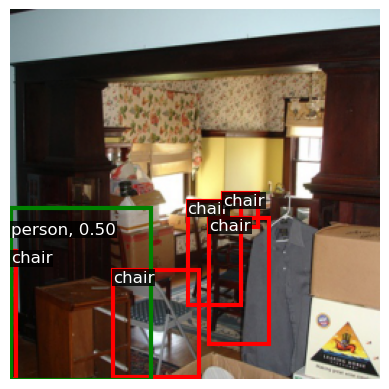

Test image# 1
No box predictions for this image!
Test image# 2


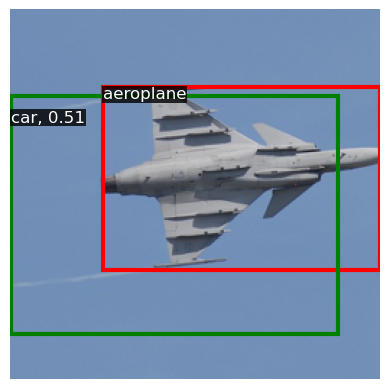

Test image# 3
No box predictions for this image!
Test image# 4


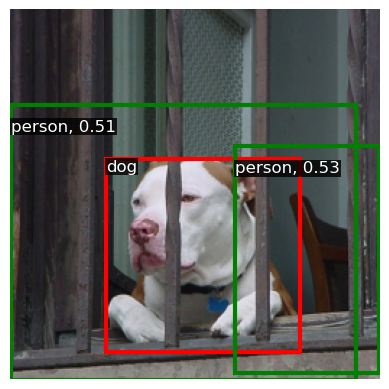

Test image# 5


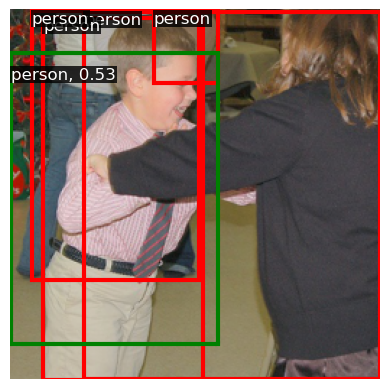

Test image# 6
No box predictions for this image!
Test image# 7
No box predictions for this image!
Test image# 8


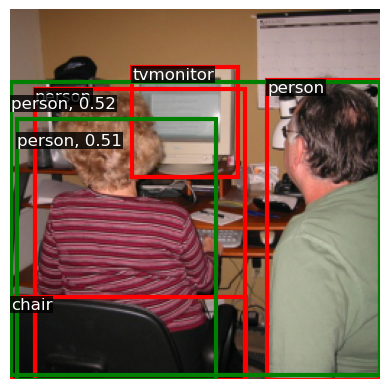

Test image# 9
No box predictions for this image!
Test image# 10
No box predictions for this image!
Test image# 11


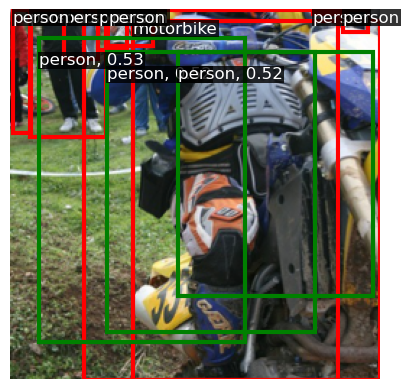

Test image# 12
No box predictions for this image!
Test image# 13
No box predictions for this image!
Test image# 14


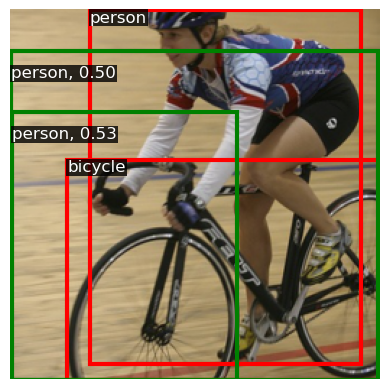

Test image# 15


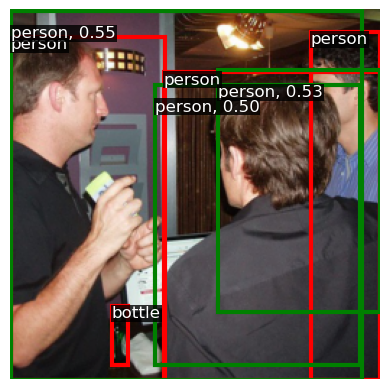

Test image# 16


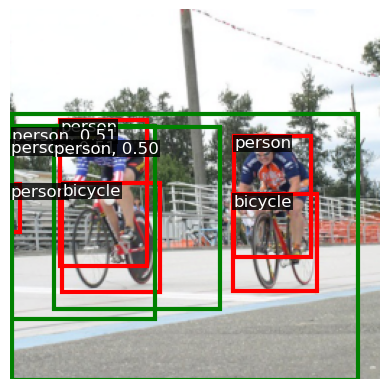

Test image# 17
No box predictions for this image!
Test image# 18


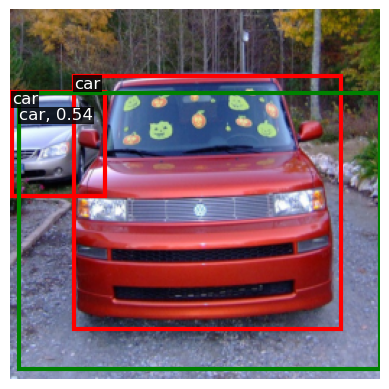

Test image# 19
No box predictions for this image!
Test image# 20
No box predictions for this image!
Test image# 21
No box predictions for this image!
Test image# 22


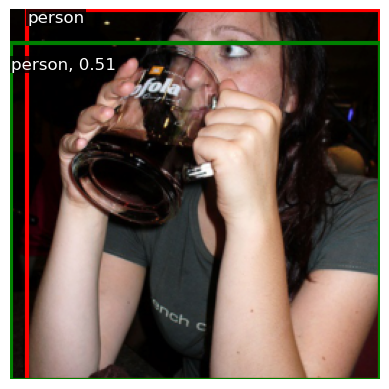

Test image# 23
No box predictions for this image!
Test image# 24
No box predictions for this image!
Test image# 25
No box predictions for this image!
Test image# 26
No box predictions for this image!
Test image# 27
No box predictions for this image!
Test image# 28
No box predictions for this image!
Test image# 29
No box predictions for this image!
Test image# 30
No box predictions for this image!
Test image# 31
No box predictions for this image!


In [20]:
small_val_dataset = torch.utils.data.Subset(val_dataset, torch.linspace(0, len(train_dataset) - 1, steps=batch_size * 2).long())
small_val_loader = torch.utils.data.DataLoader(small_val_dataset, batch_size=1, pin_memory=True, num_workers=num_workers)
test(model, small_val_loader, idx2class=train_dataset.idx2class, score_threshold=0.5, nms_threshold=0.5, device=device)